In [157]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import os
import glob
import copy
import pickle

from BSA3_pack import *

from struct import unpack
from scipy import signal
from tqdm import tqdm_notebook
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import Angle
from itertools import permutations


import numpy as np
import matplotlib.pyplot as plt

In [44]:
pulsar = '1237+25'

In [513]:
%%time
big_filename = './data_pntht/1133+16/010618_21_N2_00.pnthr'
filename = './data_pnt/' + pulsar + '/310518_22_N1_00.pnt'
# filename = './data_pnt/1237+25/040518_00_N1_00.pnt'
header, data = read_pnt(filename)

CPU times: user 20 ms, sys: 44 ms, total: 64 ms
Wall time: 1.04 s


In [514]:
print('npoints = ', len(data), '\n',
      'modules = ', len(data[0]), '\n',
      'rays = ', len(data[0][0]), '\n',
      'bands = ', len(data[0][0][0]))

npoints =  36018 
 modules =  6 
 rays =  8 
 bands =  7


In [515]:
obs_points = 5*u.min/(float(header['tresolution'][0])*u.millisecond).to(u.min)
obs_points = int(round(obs_points.value, 0))
print(obs_points)

3002


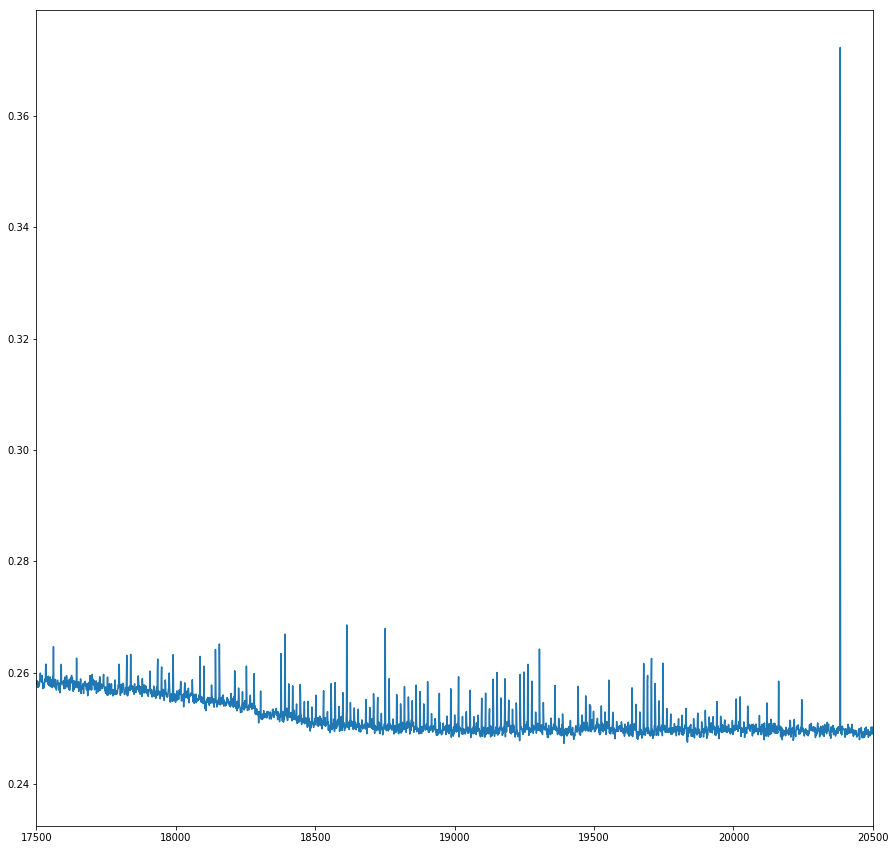

CPU times: user 292 ms, sys: 4 ms, total: 296 ms
Wall time: 297 ms


In [518]:
%%time
module_1 = 6
module_2 = 5
ray_1 = 1
ray_2 = 8
chanel = 7
start_p = 17500
stop_p = start_p + obs_points

fig, ax = plt.subplots(figsize=(15, 15))

ax.plot([j[module_1-1][ray_1-1][chanel-1] for j in data])
#ax.plot([j[module_2-1][ray_2-1][chanel-1] for j in data])
plt.xlim(start_p, stop_p)
plt.show()

In [519]:
puls_data = [j[module_1-1][ray_1-1][chanel-1] for j in data[start_p:stop_p]]

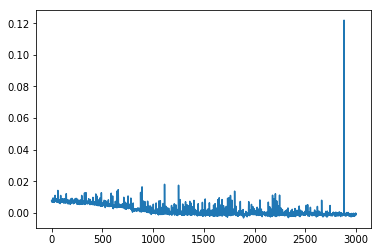

In [520]:
sig = puls_data - np.median(puls_data)
plt.plot(sig)
plt.show()

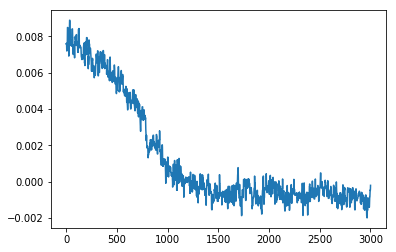

In [521]:
res_filter = signal.medfilt(sig, kernel_size=7)
plt.plot(res_filter)
plt.show()

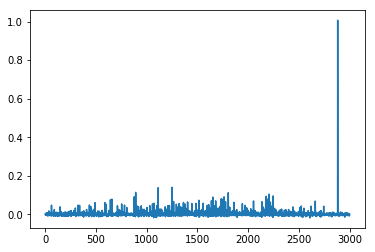

In [522]:
filtred_sig = (sig - res_filter)/max(sig)
plt.plot(filtred_sig)
plt.show()

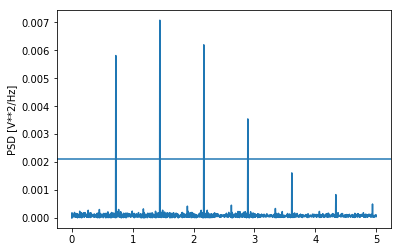

In [523]:
fs = 10 # понять физический смысл этого числа
f, Pxx_den = signal.periodogram(filtred_sig, fs)
plt.plot(f, Pxx_den)
plt.ylabel('PSD [V**2/Hz]')
plt.axhline(0.3*max(Pxx_den))
#plt.ylim(0, 0.00003)
#plt.xlim(0.2, 5)
plt.show()

In [524]:
_, points = np.where([Pxx_den > 0.3*max(Pxx_den)])

In [525]:
for i in points:
    print(f[i], f[i]/f[points[0]], (f[i])/(f[i]/f[points[0]]))

0.7228514323784144 1.0 0.7228514323784144
1.4457028647568289 2.0 0.7228514323784144
2.1685542971352434 3.0 0.7228514323784144
2.8914057295136577 4.0 0.7228514323784144


In [526]:
# Функция для создания последовательности временных значений для оси OX
def get_time(time_start, resolution, point):
    time = time_start + point*float(resolution)*u.millisecond
    return time

In [527]:
time_start, time_end = get_time_begin_and_end(header)

In [528]:
start_point = get_time(time_start, header['tresolution'][0], start_p)

In [529]:
end_point = get_time(time_start, header['tresolution'][0], stop_p)

In [530]:
to_log = (start_point, end_point, filtred_sig,)

In [531]:
with open(os.path.basename(filename)[:-4] + '_part_' + pulsar + '.log', 'wb') as file:
    pickle.dump(to_log, file)